### 1. Import functions and libraries 

In [1]:
from utils import *
from dgp import dgp_selfdriving

### 2. Generate dataset

In [2]:
treatment_year = 2013
treated_city = 'Miami'
df = dgp_selfdriving().generate_data(year=treatment_year, city=treated_city)
df.head()

,city,year,density,employment,gdp,population,treated,post,revenue
0,Atlanta,2003,290,0.629761,6.4523,4.267538,False,False,25.713947
1,Atlanta,2004,295,0.635595,6.5836,4.349712,False,False,23.852279
2,Atlanta,2005,302,0.645614,6.6998,4.455273,False,False,24.332397
3,Atlanta,2006,313,0.648573,6.5653,4.609096,False,False,23.816017
4,Atlanta,2007,321,0.650976,6.4184,4.737037,False,False,25.786902


### 3. Use the create_table_one function from Uber's causalml package to produce a covariate balance table, containing the average value of our observable characteristics, across treatment and control groups. 

In [3]:
from causalml.match import create_table_one

create_table_one(df, 'treated', ['density', 'employment', 'gdp', 'population', 'revenue'])

,Control,Treatment,SMD
Variable,,,
n,765,17,
density,256.63 (172.90),364.94 (19.61),0.8802
employment,0.63 (0.05),0.60 (0.04),-0.5266
gdp,6.07 (1.16),5.12 (0.29),-1.1124
population,3.53 (3.81),5.85 (0.31),0.861
revenue,25.25 (2.45),23.86 (2.39),-0.5737


the groups are not balanced: Miami is more densely populated, poorer, larger and has lower employment rate than the other cities in the US in our sample.

One initial idea could be to analyze the data as we would in an A/B test, comparing control and treatment group. We can estimate the treatment effect as a difference in means in revenue between the treatment and control group, after the introduction of self-driving cars.

In [4]:
smf.ols('revenue ~ treated', data=df[df['post']==True]).fit().summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,26.6006,0.127,210.061,0.000,26.351,26.850
treated[T.True],-0.7156,0.859,-0.833,0.405,-2.405,0.974


The effect of self-driving cars seems to be negative but not significant.

The main problem here is that treatment was not randomly assigned. We have a single treated unit, Miami, and it's hardly comparable to other cities.

One alternative procedure, is to compare revenue before and after the treatment, within the city of Miami.

In [5]:
smf.ols('revenue ~ post', data=df[df['city']==treated_city]).fit().summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,22.4485,0.534,42.044,0.000,21.310,23.587
post[T.True],3.4364,0.832,4.130,0.001,1.663,5.210


The effect of self-driving cars seems to be positive and statistically significant.

However, the problem of this procedure is that there might have been many other things happening after 2013. It's quite a stretch to attribute all differences to self-driving cars.

We can better understand this concern if we plot the time trend of revenue over cities. First, we need to reshape the data into a wide format, with one column per city and one row per year.

In [6]:
df = df.pivot(index='year', columns='city', values='revenue').reset_index()

In [7]:
cities = [c for c in df.columns if c!='year']
df['Other Cities'] = df[[c for c in cities if c != treated_city]].mean(axis=1)

In [8]:
def plot_lines(df, line1, line2, year, hline=True):
    f,ax = plt.subplots(figsize=(12,9))
    sns.lineplot(x=df['year'], y=df[line1].values, label=line1)
    sns.lineplot(x=df['year'], y=df[line2].values, label=line2)
    plt.axvline(x=year, ls=":", color='C2', label='Self-Driving Cars', zorder=1)
    plt.legend();
    plt.title("Average revenue per day (in M$)");

In [9]:
#  plot the revenue over time for Miami and for the other cities.
sns.set_palette(sns.color_palette(['#f14db3', '#0dc3e2', '#443a84']))

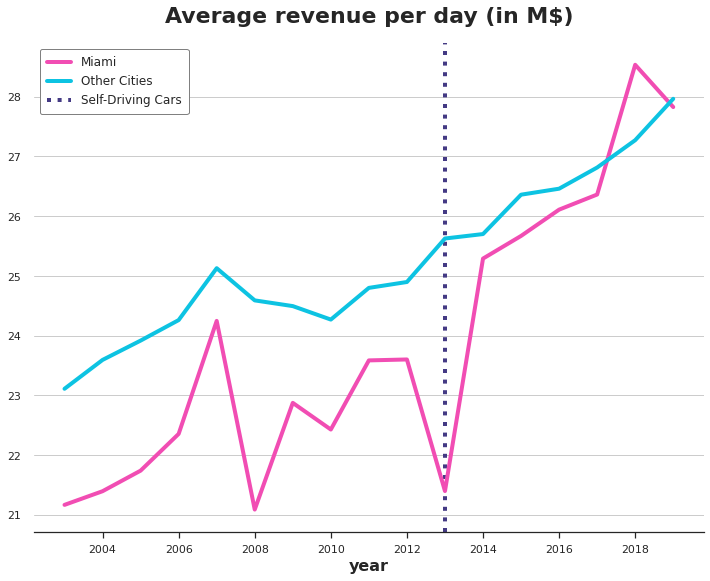

In [10]:
plot_lines(df, treated_city, 'Other Cities', treatment_year)

### 4. Use synthetic control to do causal inference

First, we write a synth_predict function that takes as input a model that is trained on control cities and tries to predict the outcome of the treated city, Miami, before the introduction of self-driving cars.

In [11]:
def synth_predict(df, model, city, year):
    other_cities = [c for c in cities if c not in ['year', city]]
    y = df.loc[df['year'] <= year, city]
    X = df.loc[df['year'] <= year, other_cities]
    df[f'Synthetic {city}'] = model.fit(X, y).predict(df[other_cities])
    return model

Let's estimate the model via linear regression.

In [12]:
from sklearn.linear_model import LinearRegression

coef = synth_predict(df, LinearRegression(), treated_city, treatment_year).coef_

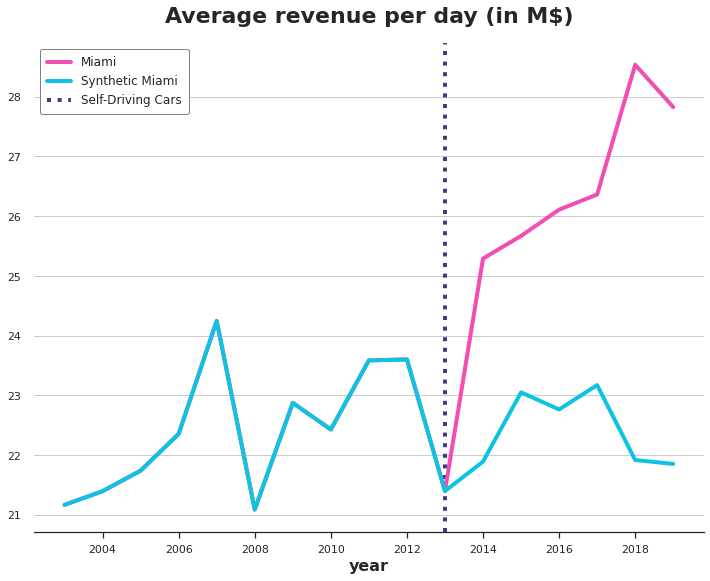

In [13]:
plot_lines(df, treated_city, f'Synthetic {treated_city}', treatment_year)

It looks like self-driving cars had a sensible positive effect on revenue in Miami: the predicted trend is lower than the actual data and diverges right after the introduction of self-driving cars.

On the other hand, we are clearly overfitting: the pre-treatment predicted revenue line is perfectly overlapping with the actual data. Given the high variability of revenue in Miami, this is suspicious, to say the least.

Another problem concerns the weights. Let's plot them.

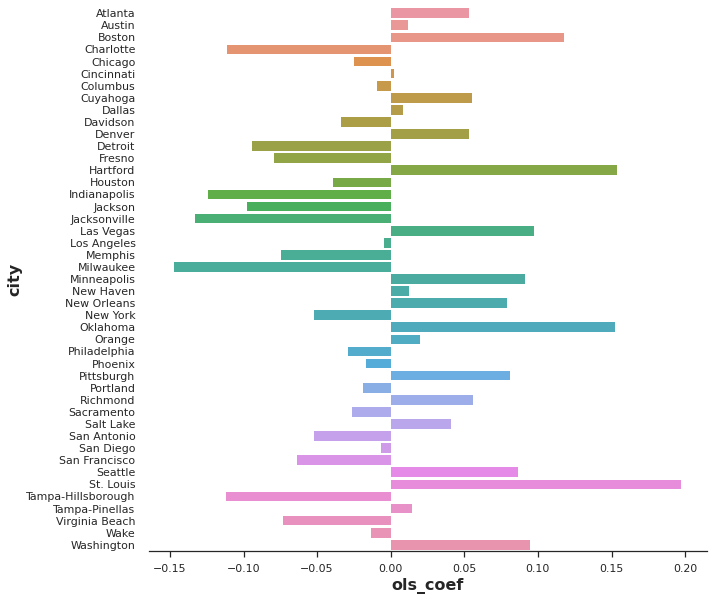

In [14]:
df_states = pd.DataFrame({'city': [c for c in cities if c!=treated_city], 'ols_coef': coef})
plt.figure(figsize=(10, 10))
sns.barplot(data=df_states, x='ols_coef', y='city');

We have many negative weights, which do not make much sense from a causal inference perspective. I can understand that Miami can be expressed as a combination of 0.2 St. Louis, 0.15 Oklahoma and 0.15 Hartford. But what does it mean that Miami is -0.15 Milwaukee?

Since we would like to interpret our synthetic control as a weighted average of untreated states, all weights should be positive and they should sum to one.

To address both concerns (weighting and overfitting), we need to impose some restrictions on the weights.

Let's write now our own objective function. I create a new class SyntheticControl()

In [15]:
from toolz import partial
from scipy.optimize import fmin_slsqp

class SyntheticControl():
    
    # Loss function
    def loss(self, W, X, y) -> float:
        return np.sqrt(np.mean((y - X.dot(W))**2))

    # Fit model
    def fit(self, X, y):
        w_start = [1/X.shape[1]]*X.shape[1]
        self.coef_ = fmin_slsqp(partial(self.loss, X=X, y=y),
                         np.array(w_start),
                         f_eqcons=lambda x: np.sum(x) - 1,
                         bounds=[(0.0, 1.0)]*len(w_start),
                         disp=False)
        self.mse = self.loss(W=self.coef_, X=X, y=y)
        return self
    
    # Predict 
    def predict(self, X):
        return X.dot(self.coef_)

We can now repeat the same procedure as before, but using the SyntheticControl method instead of the simple, unconstrained LinearRegression.

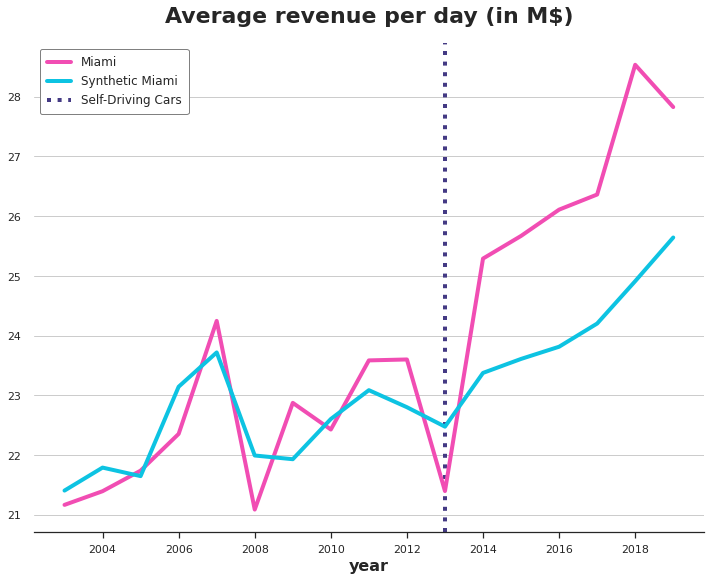

In [16]:
df_states['coef_synth'] = synth_predict(df, SyntheticControl(), treated_city, treatment_year).coef_
plot_lines(df, treated_city, f'Synthetic {treated_city}', treatment_year)

In [17]:
def plot_difference(df, city, year, vline=True, hline=True, **kwargs):   
    sns.lineplot(x=df['year'], y=df[city] - df[f'Synthetic {city}'], **kwargs)
    if vline: 
        plt.axvline(x=year, ls=":", color='C2', lw=3, label='Self-driving Cars', zorder=100)
        plt.legend()
    if hline: sns.lineplot(x=df['year'], y=0, lw=3, color='k', zorder=1)
    plt.title("Estimated effect of self-driving cars")

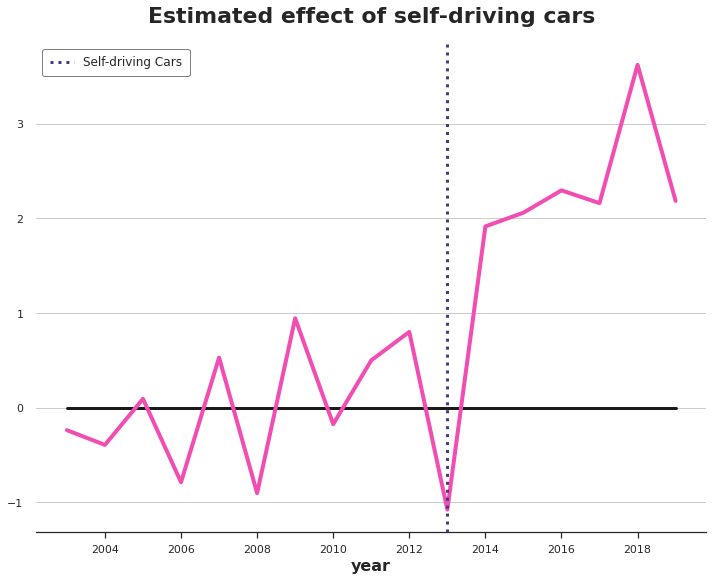

In [18]:
f,ax = plt.subplots(figsize=(12,9)) 
plot_difference(df, treated_city, treatment_year)

The difference is clearly positive and slightly increasing over time.

We can also visualize the weights to interpret the estimated counterfactual (what would have happened in Miami, without self-driving cars).

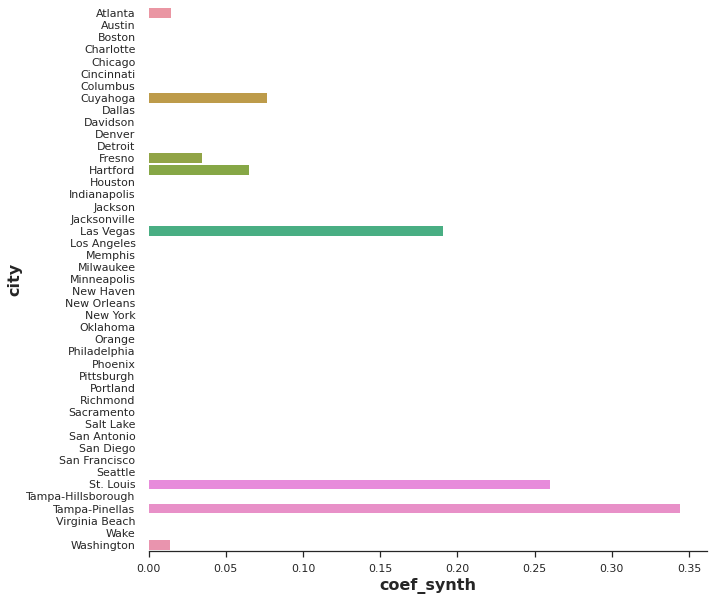

In [19]:
plt.figure(figsize=(10, 10))
sns.barplot(data=df_states, x='coef_synth', y='city');

As we can see, now we are expressing revenue in Miami as a linear combination of just a couple of cities: Tampa, St. Louis and, to a lower extent, Las Vegas. This makes the whole procedure very transparent.

### 5. Inference

We are going to perform a randomization/permutation test in order to answer this question. The idea is that if the policy has no effect, the effect we observe for Miami should not be significantly different from the effect we observe for any other city.

Therefore, we are going to replicate the procedure above, but for all other cities and compare them with the estimate for Miami.

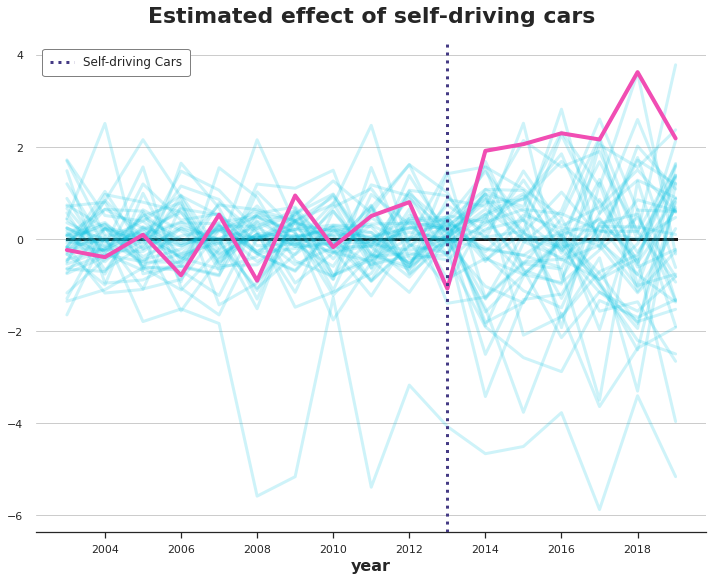

In [20]:
f,ax = plt.subplots(figsize=(12,9)) 
for city in cities:
    synth_predict(df, SyntheticControl(), city, treatment_year)
    plot_difference(df, city, treatment_year, vline=False, alpha=0.2, color='C1', lw=3)
plot_difference(df, treated_city, treatment_year)

From the graph we notice two things. First, the effect for Miami is quite extreme and therefore likely not to be driven by random noise.

Second, we also notice that there are a couple of cities for which we cannot fit the pre-trend very well. In particular, there is a line that is sensibly lower than all others. This is expected since, for each city, we are building the counterfactual trend as a convex combination of all other cities. Cities that are quite extreme in terms of revenue are very useful to build the counterfactuals of other cities, but it's hard to build a counterfactual for them.

Not to bias the analysis, let's exclude states for which we cannot build a "good enough" counterfectual, in terms of pre-treatment MSE.

As a rule of thumb, Abadie, Diamond and Hainmueller (2010) suggest to exclude units for which the prediction MSE is larger than twice the MSE of the treated unit.

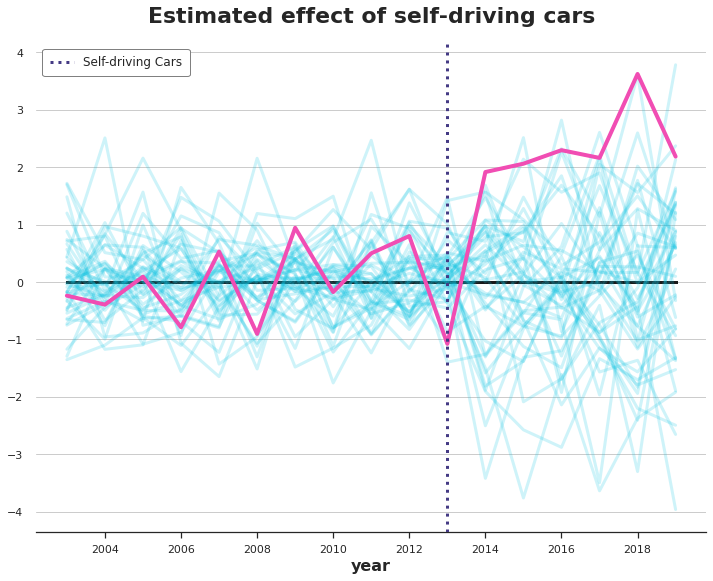

In [21]:
# Reference mse
mse_treated = synth_predict(df, SyntheticControl(), treated_city, treatment_year).mse

# Other mse
f,ax = plt.subplots(figsize=(12,9)) 
for city in cities:
    mse = synth_predict(df, SyntheticControl(), city, treatment_year).mse
    if mse < 2 * mse_treated:
        plot_difference(df, city, treatment_year, vline=False, alpha=0.2, color='C1', lw=3)
plot_difference(df, treated_city, treatment_year)

After exluding extreme observations, it looks like the effect for Miami is very unusual.

In [22]:
lambdas = {}
for city in cities:
    mse_pre = synth_predict(df, SyntheticControl(), city, treatment_year).mse
    mse_tot = np.mean((df[f'Synthetic {city}'] - df[city])**2)
    lambdas[city] = (mse_tot - mse_pre) / mse_pre
    
print(f"p-value: {np.mean(np.fromiter(lambdas.values(), dtype='float') > lambdas[treated_city]):.4}")

p-value: 0.04348


It seems that only 
 of the cities had a larger MSE ratio than Miami, implying a p-value of 0.043. We can visualize the distribution of the statistic under permutation with a histogram.

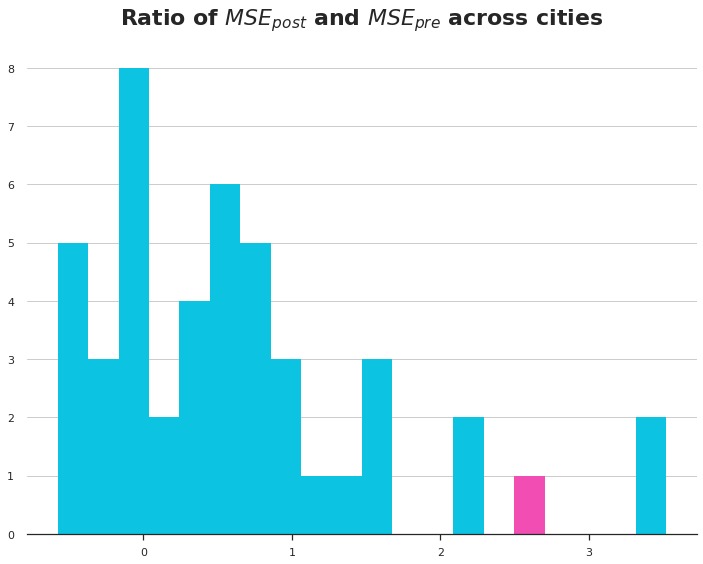

In [23]:
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
fig, ax = plt.subplots(figsize=(12,9))
_, bins, _ = plt.hist(lambdas.values(), bins=20, color="C1");
plt.hist([lambdas[treated_city]], bins=bins)
plt.title('Ratio of $MSE_{post}$ and $MSE_{pre}$ across cities');

### 6. Conclusion
we have explored a very popoular method for causal inference when we have few treated units, but many time periods. This setting emerges often in industry settings when the treatment has to be assigned at the aggregate level and randomization might not be possible. The key idea of synthetic control is to combinate control units into one syntetic control unit to use as counterfactual to estimate the causal effect of the treatment.

One of the main advantages of synthetic control is that, as long as we use positive weights that are constrained to sum to one, the method avoids extrapolation: we will never go out of the support of the data. Moreover, synthetic control studies can be "pre-registered": you can specify the weights before the study to avoid p-hacking and cherry picking. Another reason why this method is so popular in the industry is that weights make the counterfactual analysis explicit: one can look at the weights and understand which comparison we are making.